In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as dsF
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [2]:
dataset = ds.dataset(list(Path(f"new_sig/").glob("*.parquet")), format="parquet")

In [3]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    print(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'pmiss', 'cmpmiss', 'thetamiss',
       'cmthetamiss', 'cmfox', 'fox', 'asymmetry', 'p0', 'theta_Bs', 'M0',
       'recM2_Bs', 'idec0', 'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1',
       'Bs_lik', 'N_KS', 'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1',
       'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0',
       'Chi_sq_1', 'dr0', 'dr1', 'totalEnergyMC', 'E_gamma_in_ROE',
       'correct_nu_0', 'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1',
       'lost_0', 'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')


In [4]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))


<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_11636\1520325049.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [5]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_11636\1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [6]:
import json
with open("output/columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [7]:
data = get_values(dataset, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1) & mask_is1))

Total data size: 5.09 MB


In [8]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

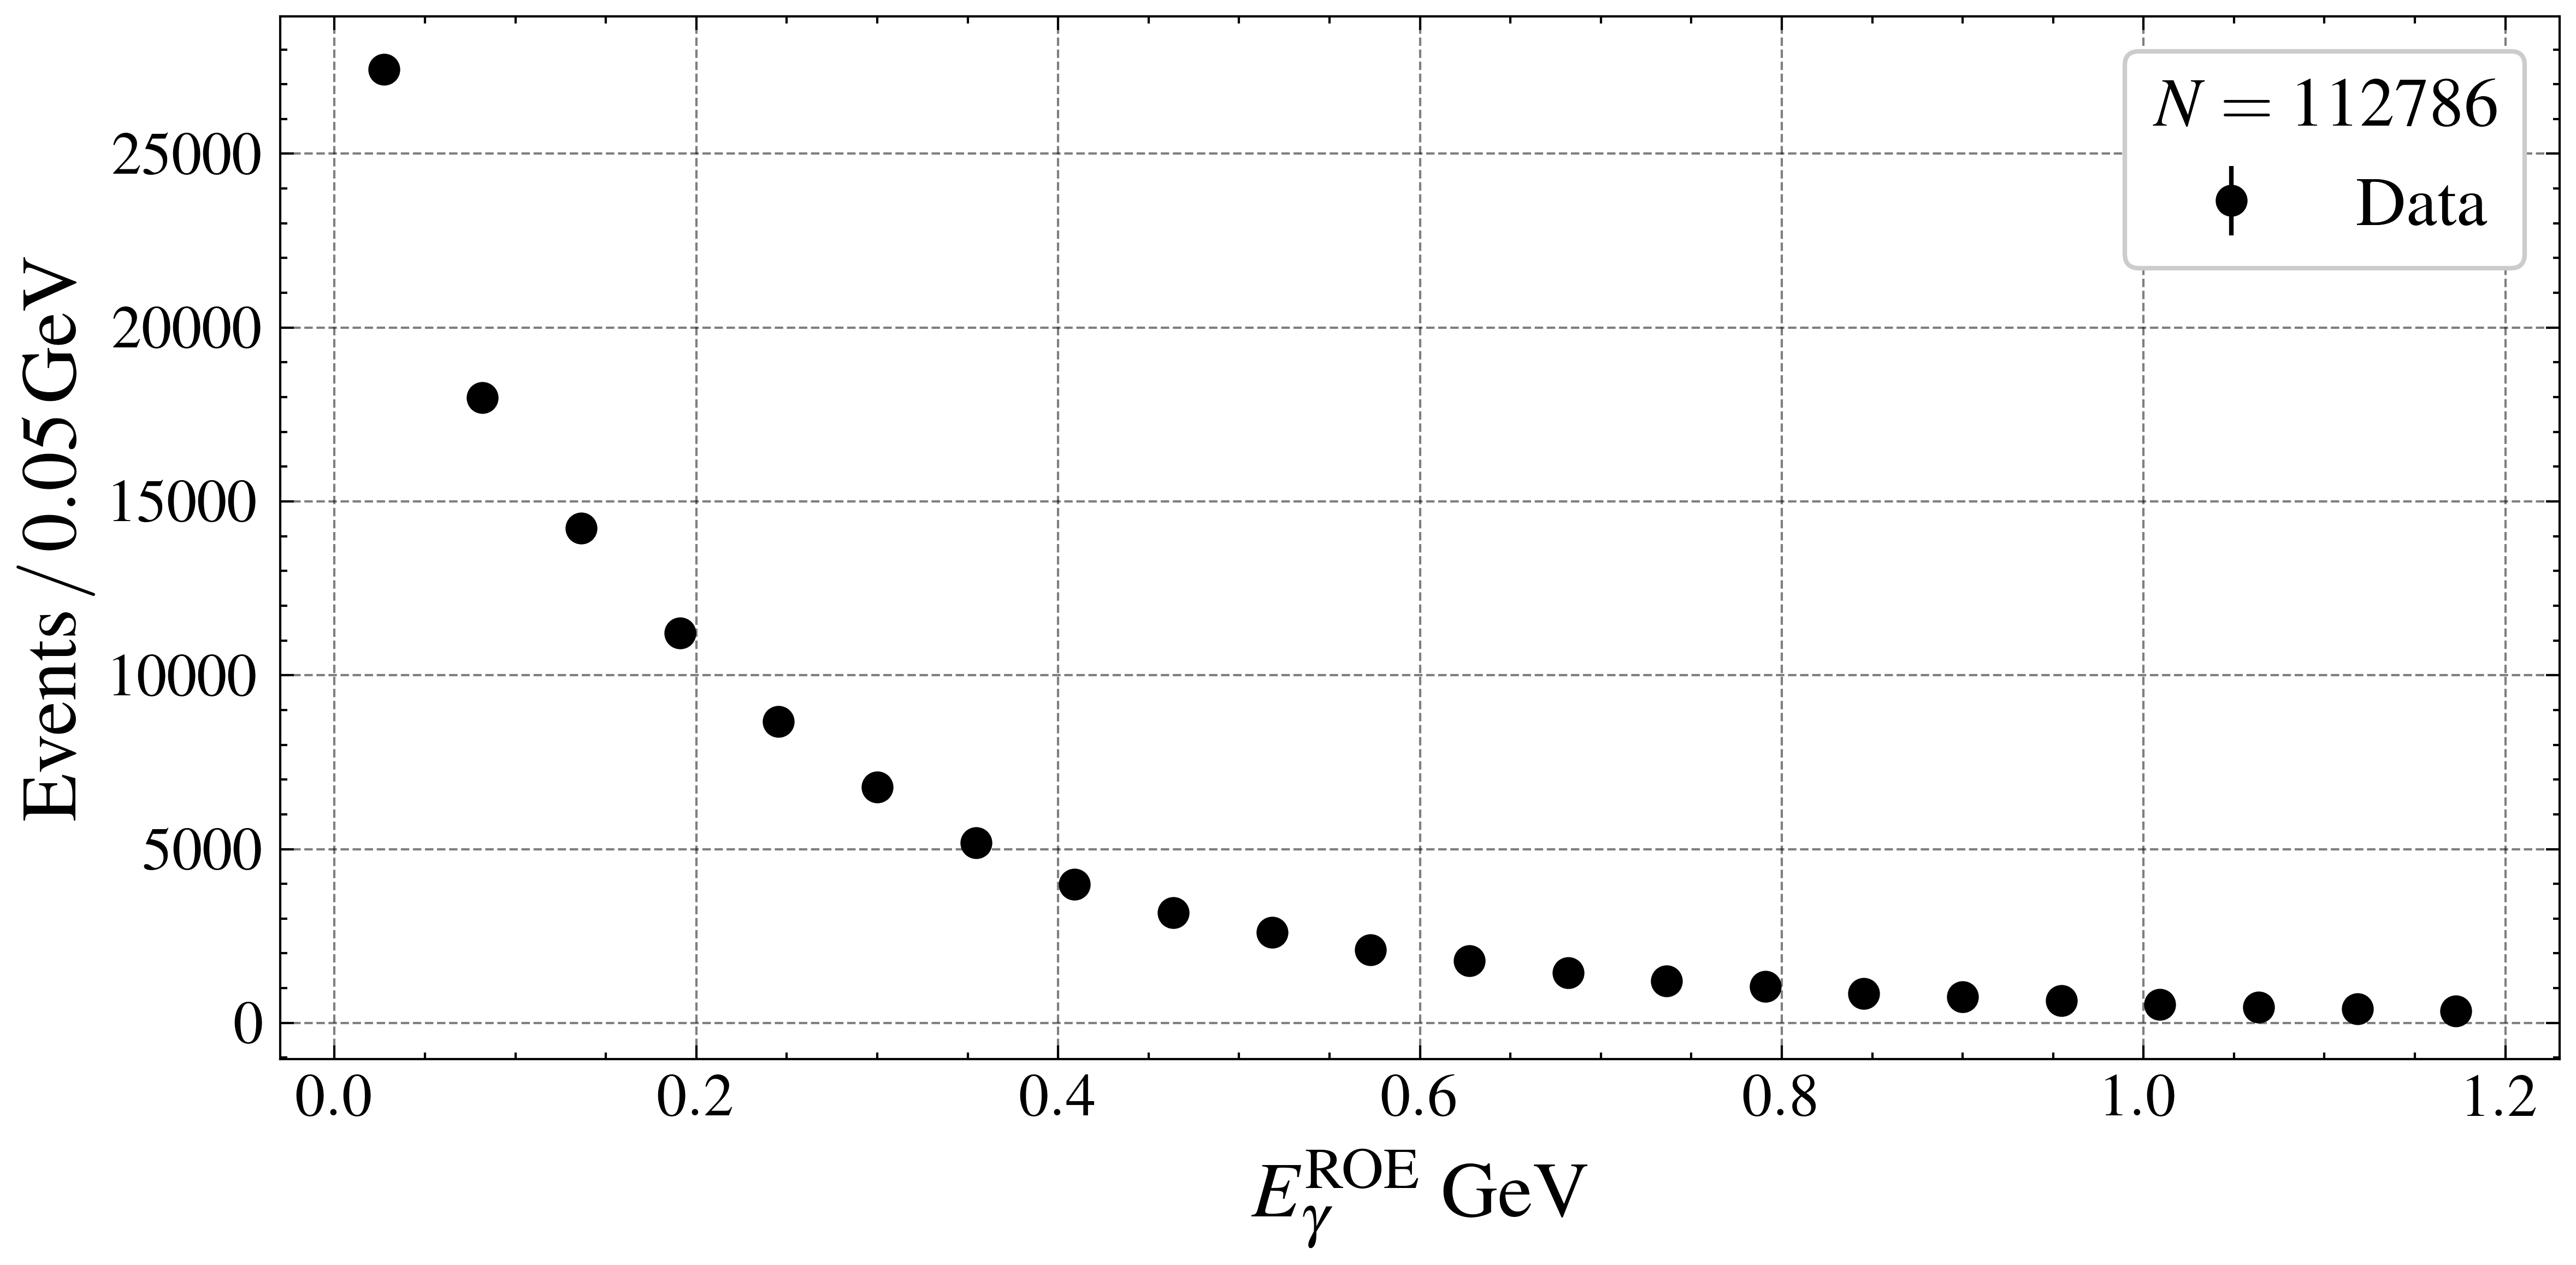

In [9]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_lep & (pc.field("is0") == 1) & mask_is1)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [10]:
@njit(fastmath=True)
def exp_dis(x, lam, a=0, b=0):
    if a == b:
        normalization_factor = 1
    else:
        normalization_factor = lam / (np.exp(lam * (b)) - np.exp(lam * (a)))
    return normalization_factor * np.exp(lam * x)

In [11]:
BS0 = 5.366691

In [12]:
wbin_x, a_x, b_x = 0.05, 0, 1.2
wbin_y, a_y, b_y = 0.005, BS0-0.05, BS0+0.05

bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

In [13]:
bin_centers, counts, N = compute_nd_histogram(dataset, [bins_x, bins_y], ["E_gamma_in_ROE", "M0"], filter_mask = mask & mask_lep & (pc.field("is0") == 1) & mask_is1)

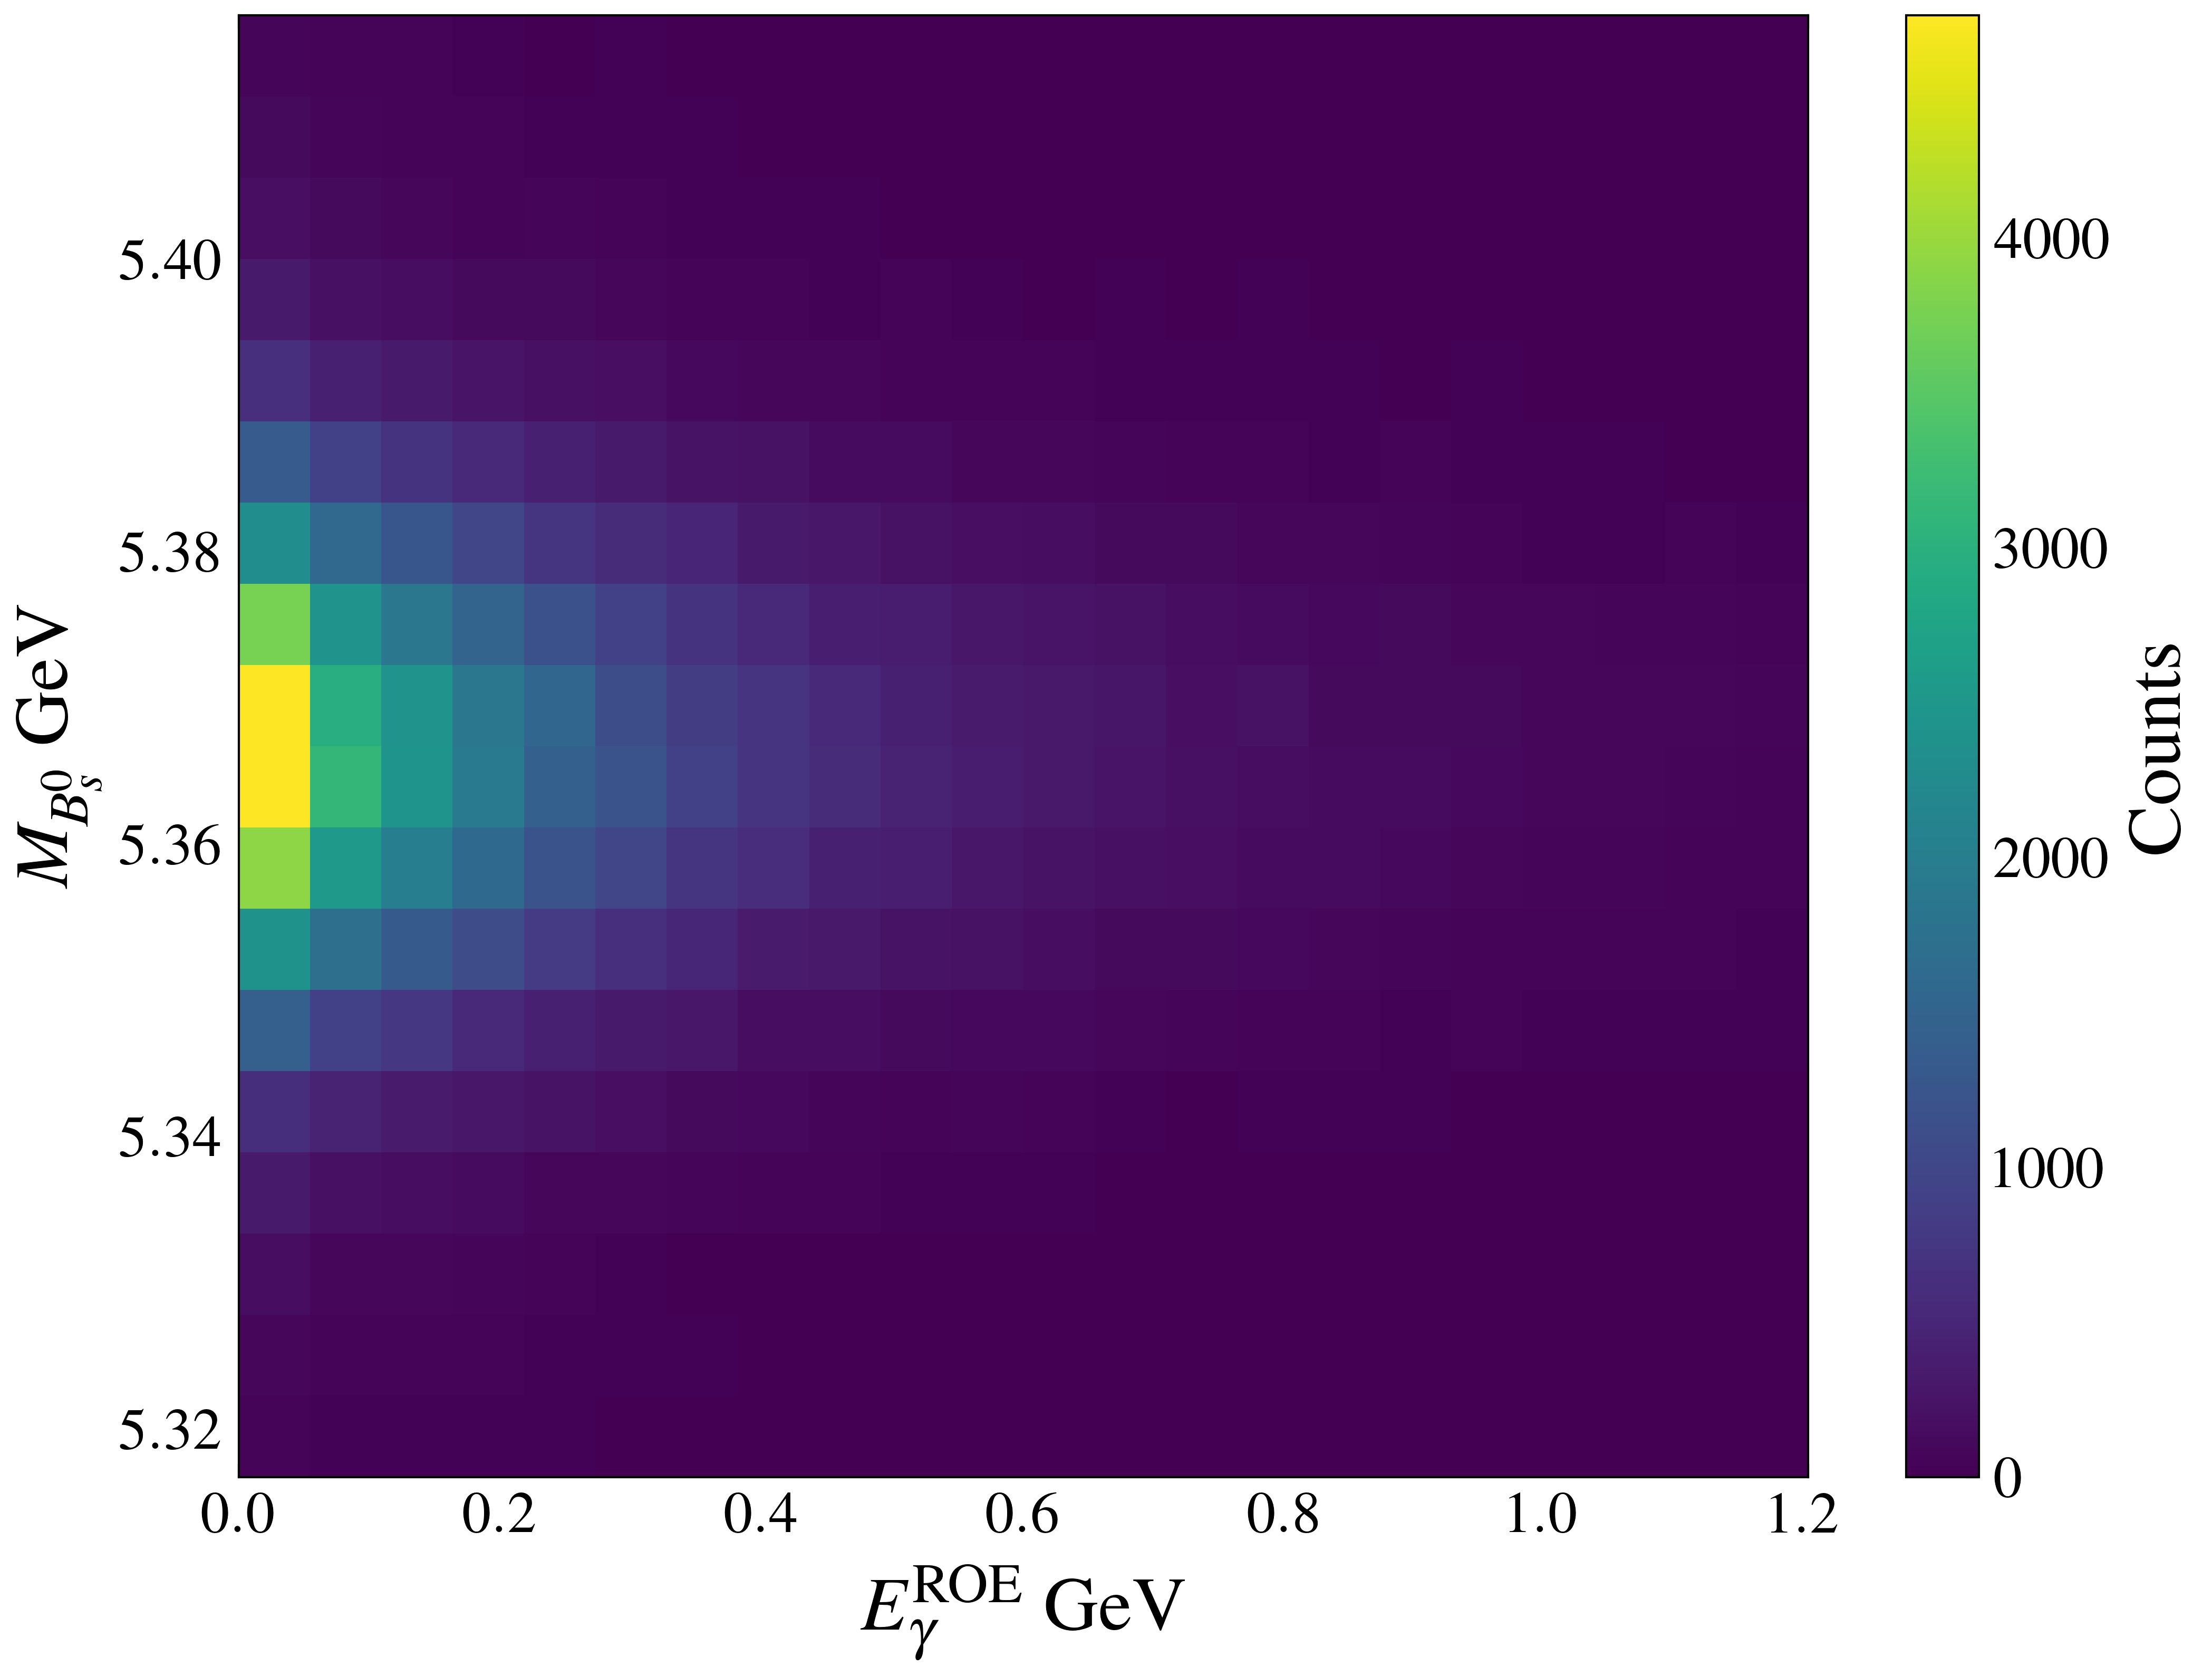

In [14]:

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}} \ \mathrm{GeV}$")
plt.ylabel(r"$M_{B_s^0}\ \mathrm{GeV}$")
plt.colorbar(pmesh, label="Counts")
plt.savefig("output/sig_E_ROE_M_Bs.pdf", dpi=700)
plt.show()

In [15]:
def f_E_g_lep_gamma(x, k, theta):
    from scipy.special import gamma
    x = x
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base

In [16]:
def f_sig(x, *, k, theta, mu, sig1, sig2, A):
    return f_E_g_lep_gamma(x[0], k, theta)*(gaussian(x[1], mu, sig1)*A + gaussian(x[1], mu, sig2)*(1 - A))

In [17]:
args = {
    "k": 0.78016,
    'theta': 1.1835581549978382, 
    "mu": BS0,
    "sig1": 0.013532784081646893,
    "sig2": 0.01,
    "A": 1.0
}

In [18]:
def max_bin_lik(f, bin_centers, counts, args0, bounds=dict(), err_need = False):
    from scipy.special import factorial

    def puasson(x, n):
        return np.exp(-x)*np.power(x, n)*np.power(factorial(n), -1)

    normalization = np.max(counts)//10
    counts = counts/normalization
    norm = np.sum(counts)
    args0["norm"] = norm

    pdf = lambda x, density = False, **args: f(x, **{k: v for k, v in args.items() if k != "norm"})/np.nansum(f(x, **{k: v for k, v in args.items() if k != "norm"})) * args["norm"] if not density else f(x, **{k: v for k, v in args.items() if k != "norm"}) * args["norm"]

    bounds["norm"] = (0, norm*10)
    def df(*arg_values):
        current_args = {k: v for k, v in zip(args0.keys(), arg_values)}
        expected = pdf(bin_centers, **current_args)
        pu = puasson(expected, counts)
        pu = np.where(pu > 1e-12, pu, 1e-12)  # защита от log(0)
        return -2 * np.sum(np.log(pu))    
    minuit = Minuit(df, *[args0[__key] for __key in args0.keys()], name=args0.keys())
    for k, bnd in bounds.items():
        minuit.limits[k] = bnd
    minuit.migrad()
    print(df(*[args0[__key] for __key in args0.keys()]))
    print(df(*[minuit.values.to_dict()[__key] for __key in minuit.values.to_dict().keys()]))
    rez = minuit.values.to_dict()
    print(rez)
    rez["norm"] = rez["norm"]* normalization
    if err_need:
        return rez, pdf, norm, minuit.errors
    return rez, pdf

In [19]:
rez, pdf = max_bin_lik(f_sig, bin_centers, counts, args)

C:\Users\matve\AppData\Local\Temp\ipykernel_11636\2846523241.py:4: RuntimeWarning: invalid value encountered in scalar power
  base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)


480.71928627934847
371.38646614658967
{'k': 0.7919395870071716, 'theta': 0.2948188228459526, 'mu': 5.366470311066482, 'sig1': 0.02341305444307565, 'sig2': 0.011463422999463112, 'A': 0.1656499870992178, 'norm': 236.66455311615093}


In [27]:
rez

{'k': 0.7919395870071716,
 'theta': 0.2948188228459526,
 'mu': 5.366470311066482,
 'sig1': 0.02341305444307565,
 'sig2': 0.011463422999463112,
 'A': 0.1656499870992178,
 'norm': np.float64(111469.00451770709)}

In [20]:
with open("output/sig_fit.json", "w") as f:
    json.dump(rez, f, indent=4)

In [21]:
plt_s = (12/1.7, 6/1.7)
pull_s = (12/6, 6/6)

In [22]:
chi = (pdf(bin_centers, **rez)-counts)**2/(np.where(counts == 0, 1, counts))/(np.sum(np.ones_like(counts)) - 6)
print(np.sum(chi))


2.0752054866182386


In [23]:

bins_x_new = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y_new = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))
dx2 = np.mean(np.diff(bins_x_new))
dy2 = np.mean(np.diff(bins_y_new))

bin_centers_new = [0.5 * (b[:-1] + b[1:]) for b in [bins_x_new, bins_y_new]]
grid_new = np.meshgrid(*bin_centers_new, indexing='ij')



In [24]:
bins_x_new = np.linspace(a_x, b_x, int((b_x - a_x) / wbin_x))
bins_y_new = np.linspace(a_y, b_y, int((b_y - a_y) / wbin_y))


bin_centers_new = [0.5 * (b[:-1] + b[1:]) for b in [bins_x_new, bins_y_new]]
bins_new_grid = np.meshgrid(*bin_centers_new , indexing='ij')
bins_x_new, bins_y_new = bin_centers_new

pdf_vals_new = pdf(bins_new_grid, norm_by_trapz=True, **rez)

dx2 = np.mean(np.diff(bins_x_new))
dy2 = np.mean(np.diff(bins_y_new))

TypeError: f_sig() got an unexpected keyword argument 'norm_by_trapz'

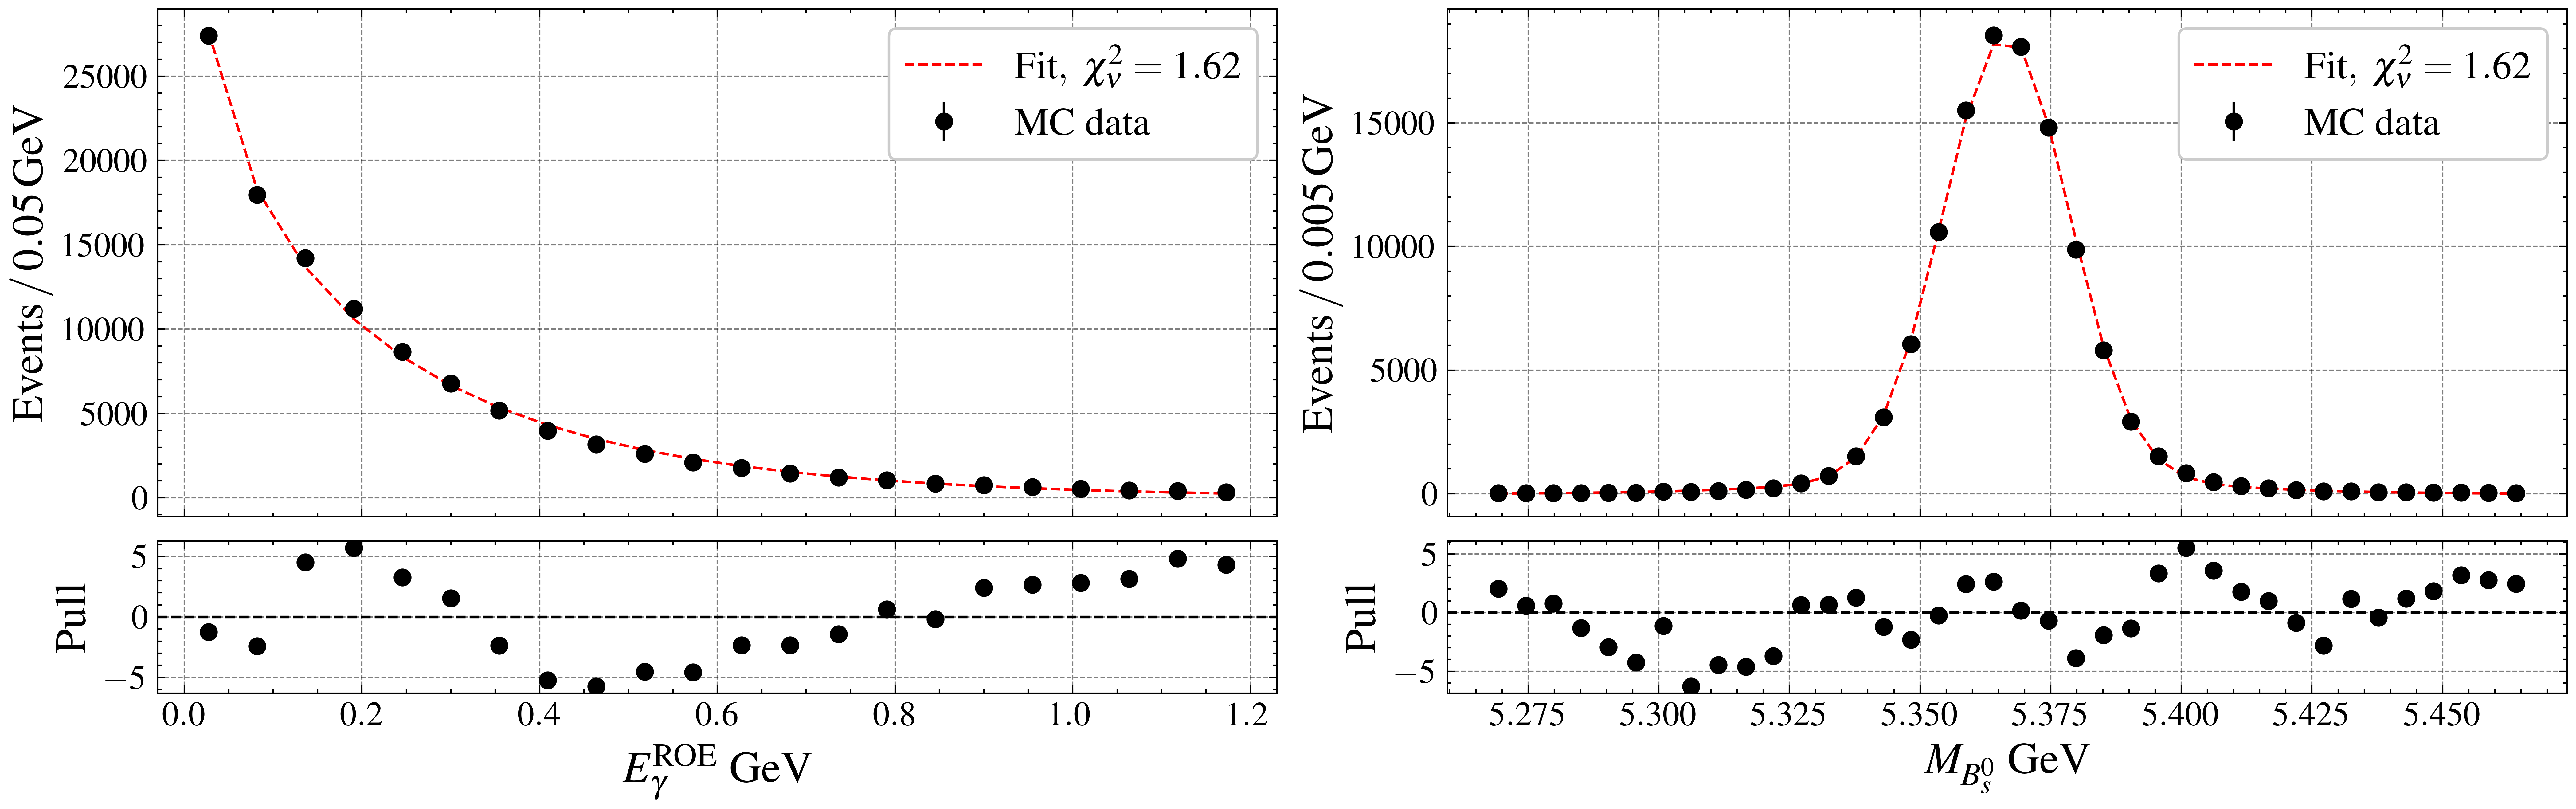

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(2*plt_s[0], plt_s[1]+pull_s[1]), 
                        gridspec_kw={'height_ratios': [1, 0.3]}, sharex='col')

counts_proj_x = np.sum(counts, axis=1)
bin_centers_x = bin_centers[0][:, 0]
fit_proj_x = np.sum(pdf(bin_centers, **rez), axis=1)

ax = axs[0, 0]
ax.errorbar(bin_centers_x, counts_proj_x, yerr=np.sqrt(counts_proj_x), fmt='o', label="MC data")
ax.plot(bin_centers_x, fit_proj_x, label=rf"$\mathrm{{Fit}}, \ \chi^2_\nu = {np.sum(chi):.2f}$")
ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_x}\,\mathrm{{GeV}}$')
ax.legend()

ax_resid = axs[1, 0]
bin_centers_x = bin_centers[0][:, 0]
fit_proj_x = np.sum(pdf(bin_centers, **rez), axis=1)
pulls_x = (counts_proj_x - fit_proj_x) / np.sqrt(np.where(counts_proj_x==0, 1, counts_proj_x))
ax_resid.plot(bin_centers_x, pulls_x, 'o')
ax_resid.axhline(0, color='black', lw=1, ls='--')
ax_resid.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax_resid.set_ylabel(r'$\mathrm{Pull}$')

counts_proj_y = np.sum(counts, axis=0)
bin_centers_y = bin_centers[1][0, :]
fit_proj_y = np.sum(pdf(bin_centers, **rez), axis=0)

ax = axs[0, 1]
ax.errorbar(bin_centers_y, counts_proj_y, yerr=np.sqrt(counts_proj_y), fmt='o', label="MC data")
ax.plot(bin_centers_y, fit_proj_y, label=rf"$\mathrm{{Fit}}, \ \chi^2_\nu = {np.sum(chi):.2f}$")
ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_y}\,\mathrm{{GeV}}$')
ax.legend()

ax_resid = axs[1, 1]
pulls_y = (counts_proj_y - fit_proj_y) / np.sqrt(np.where(counts_proj_y==0, 1, counts_proj_y))
ax_resid.plot(bin_centers_y, pulls_y, 'o')
ax_resid.axhline(0, color='black', lw=1, ls='--')
ax_resid.set_xlabel(r'$M_{B_s^0} \ \mathrm{GeV}$')
ax_resid.set_ylabel(r'$\mathrm{Pull}$')

plt.tight_layout()
plt.savefig("output/sig_fit.pdf", dpi=700)
plt.show()
